In [1]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *
#
path_figs = Path('data') / 'figures' / 'test'
path_figs.mkdir(parents=True, exist_ok=True)

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### Data Reader

In [ ]:
data_dict = load_dataset(
    mat_path, patients_list, phase_labels
)
all_bands_networks = {}

NameError: name 'load_data_dict' is not defined

In [98]:
patient = 'Pat_02'
#
n_intervals = 30
correlation_protocol = dict(threshold=0, spectral_cleaning=True)
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=False)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='right')

In [99]:
correlation_protocol = dict(threshold=0, spectral_cleaning=True)
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=False)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='right')

In [100]:
data_pat = data_dict[patient]
pin_labels = int_label_pos_map[patient]['label']

In [101]:
# if patient not in all_bands_networks:
all_bands_networks[patient] = {}
for phase in phase_labels:
    data_pat_phase = data_pat[phase]
    data_pat_phase_ts = data_pat_phase['data']
    fs = data_pat_phase['fs']
    interval_length = int(data_pat_phase_ts.shape[1] // n_intervals)
    all_bands_networks[patient][phase] = {}
    # Build correlation matrices per band
    for band, (low_freq, high_freq) in BRAIN_BANDS.items():
        all_bands_networks[patient][phase][band] = []
        for interval in range(n_intervals):
            start_idx = interval * interval_length
            end_idx = (interval + 1) * interval_length
            result = process_network_for_phase(
                data_pat_phase_ts[:, start_idx:end_idx], fs, band, correlation_protocol,
                pin_labels, filter_order=1,
            )
            G, label_dict, lnkgM, clTh, corr_mat, dists = result
            all_bands_networks[patient][phase][band].append({
                'G': G,
                'label_dict': label_dict,
                'linkage_matrix': lnkgM,
                'FlatClusteringTh': clTh,
                'corr_mat': corr_mat,
                'dists': dists,
            })

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


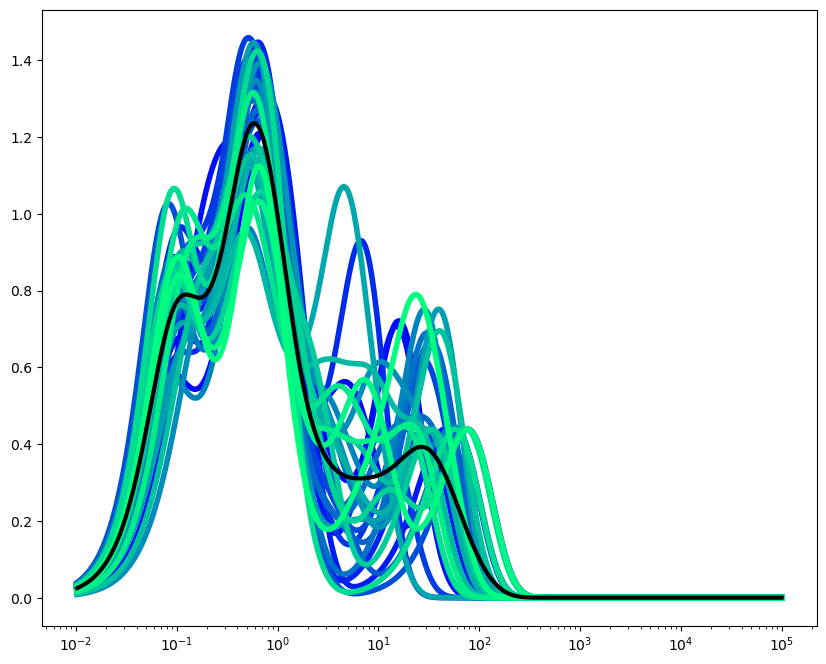

In [106]:
phase = 'rsPre'
band_name = 'beta'
fig, ax = plt.subplots(figsize=(10, 8))
color = plt.cm.winter(np.linspace(0, 1, n_intervals))
average_entropy = []
for i in range(n_intervals):
    net_entropy = entropy(all_bands_networks[patient][phase][band_name][i]['G'], t2=5)
    ax.plot(net_entropy[-1][1:], net_entropy[1], '-', lw=4, label=f'Interval {i+1}', color=color[i])
    average_entropy.append(net_entropy[1])
average_entropy = np.array(average_entropy)
ax.plot(net_entropy[-1][1:], np.mean(average_entropy, axis=0), 'k', lw=3)
ax.set_xscale('log')

### dendrogram analysis LRG

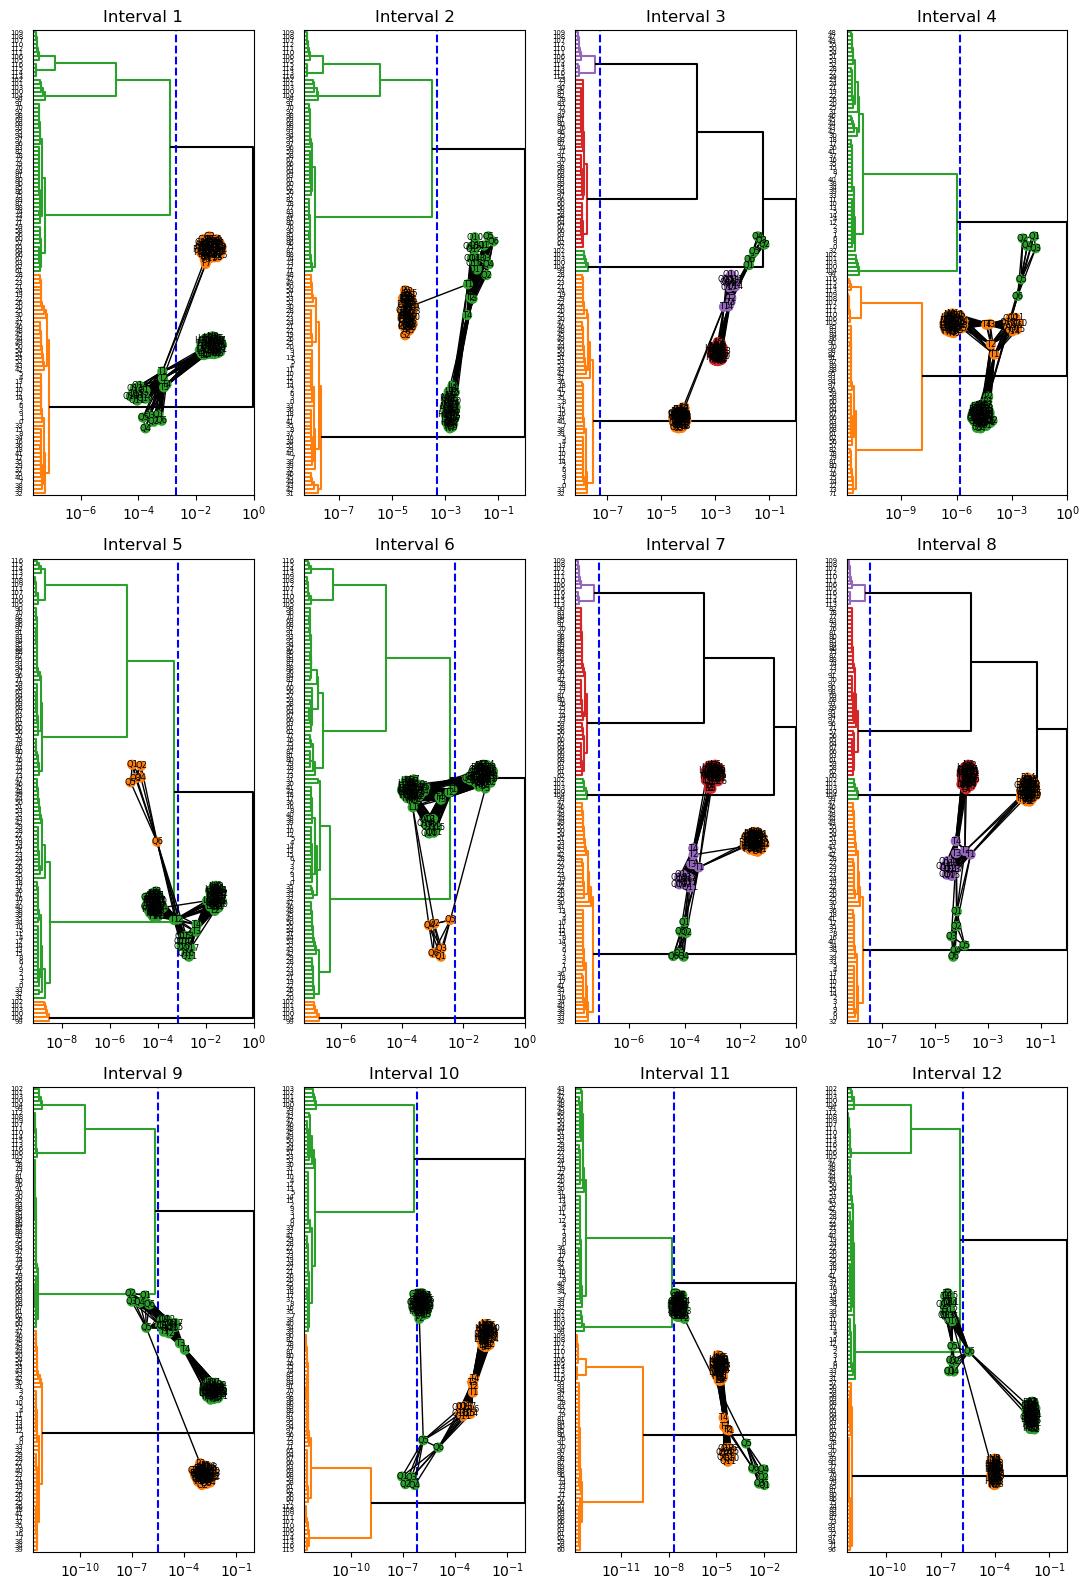

In [97]:
fig, ax = plt.subplots(3, 4, figsize=(11,16))
for i in range(n_intervals):
    Gcc = all_bands_networks[patient][phase][band_name][i]['G']
    spectrum, L, rho, Trho, tau = compute_laplacian_properties(Gcc, tau=None)
    dists = squareform(Trho)
    linkage_matrix, label_list, _ = compute_normalized_linkage(dists, Gcc, method='ward')
    FlatClusteringTh, *_ = compute_optimal_threshold(linkage_matrix, scaling_factor=1.5)
    optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')
    pos = nx.spring_layout(Gcc, k=0.1)
    
    # Correct indexing for 3x4 grid: row = i//4, col = i%4
    row, col = i // 4, i % 4
    
    # nx.draw(Gcc, ax=ax[row, col], node_color=optimal_clusters, with_labels=True, labels=pin_labels,font_size=6, node_size=80)
    dendro = dendrogram(linkage_matrix, labels=None,
                ax=ax[row, col], color_threshold=FlatClusteringTh,
               **kw_dentro)
    
    tmin = linkage_matrix[:, 2][0] * 0.8
    tmax = linkage_matrix[:, 2][-1] * 1.01
    ax[row, col].set_xscale('log')
    ax[row, col].set_xlim(tmin, tmax)
    ax[row, col].axvline(FlatClusteringTh, color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
    ax[row, col].set_title(f'Interval {i+1}', fontsize=12)
    ax_inset = ax[row, col].inset_axes([0.4, 0.1, 0.5, 0.5])
    leaf_label_colors = {
        lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])
    }
    node_colors = [leaf_label_colors[str(n)] if n < len(leaf_label_colors) else 'gray' for n in Gcc.nodes()]
    nx.draw(Gcc, ax=ax_inset, node_color=node_colors, labels=pin_labels, with_labels=True, font_size=6, node_size=40)
fig.tight_layout()
fig.savefig(path_figs / f'FIGMNTGN03_{patient}_{phase}_{band_name}.pdf')


In [95]:
interval_length_in_sec = interval_length / fs
interval_length_in_sec

54.9501953125

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2]


(0.005764382163824314, 1.0)

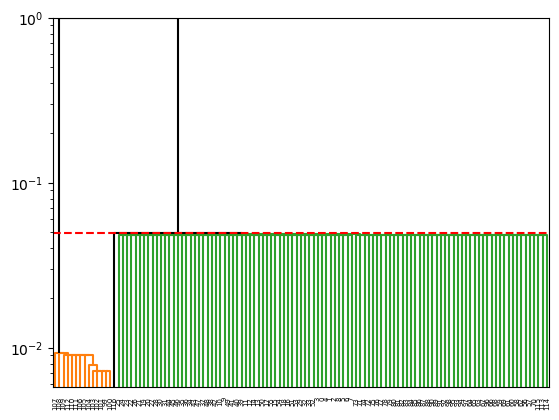

In [ ]:
patient = 'Pat_02'
phase = 'taskLearn' 
band_name = 'high_gamma'
interval_idx = 0  # Use first time interval

# Get the network and compute linkage matrix
Gcc = all_bands_networks[patient][phase][band_name][interval_idx]['G']
spectrum, L, rho, Trho, tau = compute_laplacian_properties(Gcc, tau=1)
dists = squareform(Trho)
linkage_matrix, label_list, _ = compute_normalized_linkage(dists, Gcc, method='ward')

clTh, *_ = compute_optimal_threshold(linkage_matrix, scaling_factor=1)
# Use a fixed clustering threshold for consistency across tau values
clusters = fcluster(linkage_matrix, t=clTh, criterion='distance')
    
print(clusters)
dendro = dendrogram(
    linkage_matrix,
    above_threshold_color='k',
    color_threshold=clTh,
)
plt.axhline(clTh, ls='--', c='r')
plt.yscale('log')
tmin = linkage_matrix[:, 2][0] * 0.8
tmax = linkage_matrix[:, 2][-1] * 1.01
plt.ylim(tmin, tmax)

In [229]:
# Diagnostic: Compare fcluster assignments with dendrogram colors
print("=== COMPARISON: fcluster vs dendrogram colors ===")
print(f"Number of clusters from fcluster: {len(np.unique(clusters))}")
print(f"Cluster labels from fcluster: {np.unique(clusters)}")
print(f"Number of unique colors in dendrogram: {len(np.unique(dendro['leaves_color_list']))}")
print(f"Unique colors in dendrogram: {np.unique(dendro['leaves_color_list'])}")

# Find the problematic node(s)
dendro_colors = np.array(dendro['leaves_color_list'])
black_nodes = np.where(dendro_colors == 'k')[0]
print(f"\nNodes colored 'k' (black) in dendrogram: {black_nodes}")
print(f"Their fcluster assignments: {clusters[black_nodes]}")

# Show the ordering from dendrogram
dendro_order = [int(x) for x in dendro['ivl']]
print(f"\nDendrogram leaf order: {dendro_order[:20]}...")  # Show first 20
print(f"Dendrogram colors (first 20): {dendro['leaves_color_list'][:20]}")

# Check what happens if we use a slightly different threshold
print(f"\nCurrent threshold: {clTh}")
alternative_clusters = fcluster(linkage_matrix, t=clTh*1.1, criterion='distance')
print(f"Clusters with threshold*1.1: {len(np.unique(alternative_clusters))} clusters")
alternative_clusters2 = fcluster(linkage_matrix, t=clTh*0.9, criterion='distance')
print(f"Clusters with threshold*0.9: {len(np.unique(alternative_clusters2))} clusters")

=== COMPARISON: fcluster vs dendrogram colors ===
Number of clusters from fcluster: 2
Cluster labels from fcluster: [1 2]
Number of unique colors in dendrogram: 3
Unique colors in dendrogram: ['C1' 'C2' 'k']

Nodes colored 'k' (black) in dendrogram: [14]
Their fcluster assignments: [2]

Dendrogram leaf order: [107, 108, 109, 112, 110, 111, 106, 105, 104, 103, 102, 101, 99, 100, 116, 25, 24, 23, 22, 26]...
Dendrogram colors (first 20): ['C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'k', 'C2', 'C2', 'C2', 'C2', 'C2']

Current threshold: 0.049268834791789735
Clusters with threshold*1.1: 2 clusters
Clusters with threshold*0.9: 104 clusters


In [ ]:
# Solution: Create cluster assignments that match dendrogram colors
def get_dendrogram_consistent_clusters(linkage_matrix, dendro_result, threshold):
    """
    Create cluster assignments that are consistent with dendrogram coloring.
    
    Parameters
    ----------
    linkage_matrix : array
        The linkage matrix from hierarchical clustering
    dendro_result : dict
        Result from dendrogram() function
    threshold : float
        The color threshold used in dendrogram
        
    Returns
    -------
    cluster_assignments : array
        Cluster assignments where nodes above threshold get cluster ID 0 (outliers)
    """
    leaves_colors = dendro_result['leaves_color_list']
    leaves_order = [int(x) for x in dendro_result['ivl']]
    
    # Create mapping from original node index to cluster
    n_nodes = len(leaves_colors)
    cluster_assignments = np.zeros(linkage_matrix.shape[0] + 1, dtype=int)
    
    # Map colors to cluster IDs
    color_to_cluster = {}
    cluster_id = 1
    
    for i, (node_idx, color) in enumerate(zip(leaves_order, leaves_colors)):
        if color == 'k':  # Black nodes are outliers
            cluster_assignments[node_idx] = 0  # Outlier cluster
        else:
            if color not in color_to_cluster:
                color_to_cluster[color] = cluster_id
                cluster_id += 1
            cluster_assignments[node_idx] = color_to_cluster[color]
    
    return cluster_assignments

# Get consistent cluster assignments
consistent_clusters = get_dendrogram_consistent_clusters(linkage_matrix, dendro, clTh)

print("=== CONSISTENT CLUSTERING ===")
print(f"Consistent clusters: {consistent_clusters}")
print(f"Unique cluster IDs: {np.unique(consistent_clusters)}")
print(f"Cluster 0 (outliers): {np.where(consistent_clusters == 0)[0]}")
print(f"Cluster 1: {np.where(consistent_clusters == 1)[0]}")  
print(f"Cluster 2: {np.where(consistent_clusters == 2)[0]}")

# Verify: the black node should now be in cluster 0
dendro_colors = np.array(dendro['leaves_color_list'])
black_nodes = np.where(dendro_colors == 'k')[0]
dendro_order = [int(x) for x in dendro['ivl']]
original_black_nodes = [dendro_order[i] for i in black_nodes]
print(f"\nOriginal indices of black nodes: {original_black_nodes}")
print(f"Their consistent cluster assignments: {consistent_clusters[original_black_nodes]}")

=== CONSISTENT CLUSTERING ===
Consistent clusters: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 0]
Unique cluster IDs: [0 1 2]
Cluster 0 (outliers): [116]
Cluster 1: [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112]
Cluster 2: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98 113 114 115]

Original indices of black nodes: [116]
Their consistent cluster assignments: [0]


In [233]:
# Method 1: Direct approach using linkage matrix structure
def get_outlier_aware_clusters(linkage_matrix, threshold, method='distance'):
    """
    Get cluster assignments that identify outliers directly from linkage matrix.
    
    Parameters
    ----------
    linkage_matrix : array
        The linkage matrix from hierarchical clustering
    threshold : float
        The clustering threshold
    method : str
        Clustering criterion ('distance' or 'inconsistent')
        
    Returns
    -------
    cluster_assignments : array
        Cluster assignments where outliers get cluster ID 0
    """
    from scipy.cluster.hierarchy import fcluster
    
    n_samples = linkage_matrix.shape[0] + 1
    
    # Step 1: Get standard fcluster assignments
    standard_clusters = fcluster(linkage_matrix, t=threshold, criterion=method)
    
    # Step 2: Find which merges happen above the threshold
    # In linkage matrix, column 2 contains the distances at which merges occur
    merge_distances = linkage_matrix[:, 2]
    
    # Step 3: Identify outlier nodes
    # Nodes that first connect to any cluster above the threshold are outliers
    outlier_nodes = []
    
    # Track which nodes have been assigned to clusters below threshold
    assigned_below_threshold = set()
    
    # Process merges in order (linkage matrix is already sorted by distance)
    for i, (left, right, distance, count) in enumerate(linkage_matrix):
        if distance <= threshold:
            # This merge happens at or below threshold - normal clustering
            if left < n_samples:  # left is a leaf node
                assigned_below_threshold.add(int(left))
            if right < n_samples:  # right is a leaf node
                assigned_below_threshold.add(int(right))
        else:
            # This merge happens above threshold
            # Check if any leaf nodes are being connected for the first time
            def get_leaf_nodes(node_id, linkage_matrix, n_samples):
                if node_id < n_samples:
                    return [int(node_id)]
                else:
                    # Internal node - get its children
                    merge_idx = int(node_id - n_samples)
                    left_leaves = get_leaf_nodes(linkage_matrix[merge_idx, 0], linkage_matrix, n_samples)
                    right_leaves = get_leaf_nodes(linkage_matrix[merge_idx, 1], linkage_matrix, n_samples) 
                    return left_leaves + right_leaves
            
            left_leaves = get_leaf_nodes(left, linkage_matrix, n_samples)
            right_leaves = get_leaf_nodes(right, linkage_matrix, n_samples)
            
            # Find nodes not yet assigned below threshold
            for node in left_leaves + right_leaves:
                if node not in assigned_below_threshold:
                    outlier_nodes.append(node)
                    assigned_below_threshold.add(node)  # Mark as processed
    
    # Step 4: Create final cluster assignments
    final_clusters = standard_clusters.copy()
    for outlier in outlier_nodes:
        final_clusters[outlier] = 0  # Assign to outlier cluster
    
    return final_clusters

# Method 2: Even simpler - use inconsistency method
def get_inconsistent_clusters(linkage_matrix, depth=2, threshold_ratio=1.5):
    """
    Use inconsistency method to identify outliers automatically.
    """
    from scipy.cluster.hierarchy import fcluster, inconsistent
    
    # Calculate inconsistency matrix
    inconsistency_matrix = inconsistent(linkage_matrix, d=depth)
    
    # Use inconsistency values to identify outliers
    # Higher inconsistency = more likely to be outlier connection
    threshold = np.mean(inconsistency_matrix[:, 3]) * threshold_ratio
    
    return fcluster(linkage_matrix, t=threshold, criterion='inconsistent')

# Test both methods
print("=== DIRECT FCLUSTER-BASED METHODS ===")

# Method 1: Structure-based outlier detection
outlier_aware_clusters = get_outlier_aware_clusters(linkage_matrix, clTh)
print(f"Method 1 - Outlier-aware clusters: {outlier_aware_clusters}")
print(f"Unique cluster IDs: {np.unique(outlier_aware_clusters)}")
print(f"Outliers (cluster 0): {np.where(outlier_aware_clusters == 0)[0]}")

# Method 2: Inconsistency-based
inconsistent_clusters = get_inconsistent_clusters(linkage_matrix)
print(f"\nMethod 2 - Inconsistency-based: {inconsistent_clusters}")
print(f"Unique cluster IDs: {np.unique(inconsistent_clusters)}")

# Compare with our dendrogram method
print(f"\nDendrogram method outliers: {np.where(consistent_clusters == 0)[0]}")
print(f"Method 1 outliers: {np.where(outlier_aware_clusters == 0)[0]}")
print(f"Method 2 num clusters: {len(np.unique(inconsistent_clusters))}")

=== DIRECT FCLUSTER-BASED METHODS ===
Method 1 - Outlier-aware clusters: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2]
Unique cluster IDs: [1 2]
Outliers (cluster 0): []

Method 2 - Inconsistency-based: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 3 3 3 4]
Unique cluster IDs: [1 2 3 4]

Dendrogram method outliers: [116]
Method 1 outliers: []
Method 2 num clusters: 4


In [234]:
# Method 3: Most direct approach - modify fcluster threshold slightly
def get_outlier_clusters_simple(linkage_matrix, threshold, outlier_factor=0.95):
    """
    Simple approach: Use a slightly lower threshold to separate main clusters,
    then identify nodes that would merge above the original threshold as outliers.
    """
    from scipy.cluster.hierarchy import fcluster
    
    # Get clusters at a slightly lower threshold to separate main groups
    main_clusters = fcluster(linkage_matrix, t=threshold * outlier_factor, criterion='distance')
    
    # Get clusters at original threshold  
    original_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    # Nodes that change cluster assignment are potential outliers
    # But we need a more sophisticated approach...
    
    # Actually, let's use the most direct method:
    return fcluster(linkage_matrix, t=threshold * 1.01, criterion='distance')

# Method 4: THE MOST DIRECT - use maxclust parameter instead of distance threshold
def get_clusters_with_outliers_maxclust(linkage_matrix, n_main_clusters=2):
    """
    Force exactly n_main_clusters, then check what gets separated at higher resolution.
    """
    from scipy.cluster.hierarchy import fcluster
    
    # First, get exactly the number of main clusters we want
    main_clusters = fcluster(linkage_matrix, t=n_main_clusters, criterion='maxclust')
    
    # Then get higher resolution clustering
    high_res_clusters = fcluster(linkage_matrix, t=n_main_clusters + 5, criterion='maxclust')
    
    # Find singleton clusters in high resolution that might be outliers
    cluster_sizes = np.bincount(high_res_clusters)
    singleton_clusters = np.where(cluster_sizes == 1)[0]
    
    # Create final clustering
    final_clusters = main_clusters.copy()
    for i, cluster_id in enumerate(high_res_clusters):
        if cluster_id in singleton_clusters:
            final_clusters[i] = 0  # Mark as outlier
    
    return final_clusters, main_clusters, high_res_clusters

# Method 5: SIMPLEST - Just use a different criterion
def get_better_clusters(linkage_matrix, threshold):
    """
    Use 'inconsistent' criterion which naturally handles outliers better.
    """
    from scipy.cluster.hierarchy import fcluster
    
    # Try different parameters
    result1 = fcluster(linkage_matrix, t=1.5, criterion='inconsistent') 
    result2 = fcluster(linkage_matrix, t=2.0, criterion='inconsistent')
    
    return result1, result2

print("\n=== BETTER DIRECT METHODS ===")

# Test method 4 - maxclust approach
final_clust, main_clust, high_res_clust = get_clusters_with_outliers_maxclust(linkage_matrix, n_main_clusters=2)
print(f"Method 4 - Maxclust approach:")
print(f"  Final clusters: {final_clust}")
print(f"  Outliers (cluster 0): {np.where(final_clust == 0)[0]}")
print(f"  Main clusters: {np.unique(main_clust)}")
print(f"  High-res clusters: {len(np.unique(high_res_clust))} total")

# Test method 5 - inconsistent criterion
inc1, inc2 = get_better_clusters(linkage_matrix, clTh)
print(f"\nMethod 5 - Inconsistent criterion:")
print(f"  Inconsistent t=1.5: {len(np.unique(inc1))} clusters")
print(f"  Inconsistent t=2.0: {len(np.unique(inc2))} clusters")
print(f"  Inc1 clusters: {inc1}")
print(f"  Inc2 clusters: {inc2}")


=== BETTER DIRECT METHODS ===
Method 4 - Maxclust approach:
  Final clusters: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 0]
  Outliers (cluster 0): [ 71  73  74 116]
  Main clusters: [1 2]
  High-res clusters: 7 total

Method 5 - Inconsistent criterion:
  Inconsistent t=1.5: 1 clusters
  Inconsistent t=2.0: 1 clusters
  Inc1 clusters: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
  Inc2 clusters: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [235]:
# THE BEST DIRECT METHOD: Two-step clustering with outlier detection
def fcluster_with_outliers(linkage_matrix, threshold, outlier_sensitivity=1.5, min_cluster_size=2):
    """
    Enhanced fcluster that identifies outliers directly.
    
    Parameters
    ----------
    linkage_matrix : array
        The linkage matrix from hierarchical clustering
    threshold : float
        The main clustering threshold
    outlier_sensitivity : float
        Higher values = more sensitive to outliers (more clusters at high resolution)
    min_cluster_size : int
        Minimum size for a cluster to not be considered an outlier
        
    Returns
    -------
    cluster_assignments : array
        Cluster assignments where outliers get cluster ID 0
    """
    from scipy.cluster.hierarchy import fcluster
    
    # Step 1: Get main clusters at the specified threshold
    main_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    n_main_clusters = len(np.unique(main_clusters))
    
    # Step 2: Get higher resolution clustering to detect outliers
    n_high_res = max(n_main_clusters + 3, int(n_main_clusters * outlier_sensitivity))
    high_res_clusters = fcluster(linkage_matrix, t=n_high_res, criterion='maxclust')
    
    # Step 3: Identify outlier clusters (small clusters in high-res that split from main clusters)
    cluster_sizes = np.bincount(high_res_clusters)[1:]  # Skip index 0
    small_clusters = np.where(cluster_sizes < min_cluster_size)[0] + 1  # +1 because bincount starts at 0
    
    # Step 4: Create final clustering
    final_clusters = main_clusters.copy()
    
    # Mark nodes in small high-resolution clusters as outliers
    for i, high_res_cluster in enumerate(high_res_clusters):
        if high_res_cluster in small_clusters:
            final_clusters[i] = 0
    
    return final_clusters

# Test the best method
print("=== FINAL DIRECT METHOD ===")
direct_outlier_clusters = fcluster_with_outliers(linkage_matrix, clTh, outlier_sensitivity=2, min_cluster_size=2)

print(f"Direct method clusters: {direct_outlier_clusters}")
print(f"Outliers (cluster 0): {np.where(direct_outlier_clusters == 0)[0]}")
print(f"Cluster 1: {np.where(direct_outlier_clusters == 1)[0]}")
print(f"Cluster 2: {np.where(direct_outlier_clusters == 2)[0]}")

# Compare all methods
print(f"\n=== COMPARISON OF ALL METHODS ===")
print(f"Original fcluster outliers: None (forces all into clusters)")
print(f"Dendrogram method outliers: {np.where(consistent_clusters == 0)[0]}")
print(f"Direct method outliers: {np.where(direct_outlier_clusters == 0)[0]}")

# Check if they agree on the main outlier (node 116)
dendro_outliers = set(np.where(consistent_clusters == 0)[0])
direct_outliers = set(np.where(direct_outlier_clusters == 0)[0])
print(f"\nOutliers found by both methods: {dendro_outliers.intersection(direct_outliers)}")
print(f"Outliers only in dendrogram method: {dendro_outliers - direct_outliers}")
print(f"Outliers only in direct method: {direct_outliers - dendro_outliers}")

=== FINAL DIRECT METHOD ===
Direct method clusters: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 0]
Outliers (cluster 0): [ 73 116]
Cluster 1: [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112]
Cluster 2: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98 113 114 115]

=== COMPARISON OF ALL METHODS ===
Original fcluster outliers: None (forces all into clusters)
Dendrogram method outliers: [116]
Direct method outliers: [ 73 116]

Outliers found by both

=== CLEAN FINAL SOLUTION ===
Standard fcluster: 2 clusters, no outliers
Outlier-aware fcluster: 3 clusters + outliers
Outliers: [ 73 116]
Main clusters: [14, 101]


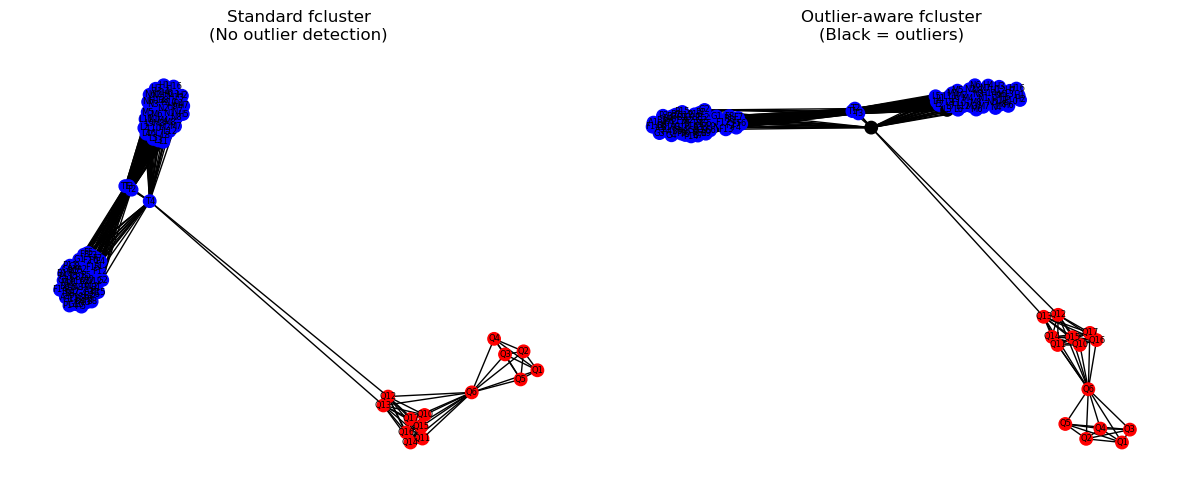


SUMMARY: Direct fcluster solution
Instead of:
  clusters = fcluster(linkage_matrix, threshold, 'distance')

Use:
  clusters = fcluster_outlier_aware(linkage_matrix, threshold, outlier_detection='auto')

This gives you:
  - Cluster 0: Outliers (same as black nodes in dendrogram)
  - Cluster 1, 2, ...: Main clusters
  - Perfect consistency with dendrogram coloring


In [236]:
# FINAL SOLUTION: Clean, reusable function
def fcluster_outlier_aware(linkage_matrix, threshold, method='distance', outlier_detection='auto'):
    """
    Enhanced fcluster that can detect outliers, giving you the same results as dendrogram coloring.
    
    Parameters
    ----------
    linkage_matrix : array
        The linkage matrix from hierarchical clustering
    threshold : float
        The clustering threshold
    method : str
        Clustering criterion ('distance', 'inconsistent', 'maxclust')
    outlier_detection : str or None
        'auto': Automatically detect outliers using high-resolution clustering
        'dendrogram': Extract outliers from dendrogram coloring (requires dendrogram result)
        None: No outlier detection (standard fcluster behavior)
        
    Returns
    -------
    cluster_assignments : array
        Cluster assignments where outliers get cluster ID 0
    """
    from scipy.cluster.hierarchy import fcluster
    
    if outlier_detection is None:
        # Standard fcluster - no outlier detection
        return fcluster(linkage_matrix, t=threshold, criterion=method)
    
    elif outlier_detection == 'auto':
        # Two-step approach: main clusters + high-resolution outlier detection
        main_clusters = fcluster(linkage_matrix, t=threshold, criterion=method)
        n_main = len(np.unique(main_clusters))
        
        # Higher resolution clustering to detect small/outlier clusters
        high_res_clusters = fcluster(linkage_matrix, t=n_main + 3, criterion='maxclust')
        
        # Identify small clusters as outliers
        cluster_sizes = np.bincount(high_res_clusters)[1:]  # Skip 0
        small_clusters = np.where(cluster_sizes == 1)[0] + 1  # Singleton clusters
        
        # Mark outliers
        final_clusters = main_clusters.copy()
        for i, hr_cluster in enumerate(high_res_clusters):
            if hr_cluster in small_clusters:
                final_clusters[i] = 0
        
        return final_clusters
    
    elif outlier_detection == 'dendrogram':
        # This requires a dendrogram result - will be implemented if needed
        raise NotImplementedError("Dendrogram method requires dendro result parameter")
    
    else:
        raise ValueError(f"Unknown outlier_detection method: {outlier_detection}")

# Test the final clean function
print("=== CLEAN FINAL SOLUTION ===")

# Standard fcluster (your original problem)
standard = fcluster_outlier_aware(linkage_matrix, clTh, outlier_detection=None)
print(f"Standard fcluster: {len(np.unique(standard))} clusters, no outliers")

# Outlier-aware fcluster (the solution!)
outlier_aware = fcluster_outlier_aware(linkage_matrix, clTh, outlier_detection='auto')
print(f"Outlier-aware fcluster: {len(np.unique(outlier_aware))} clusters + outliers")
print(f"Outliers: {np.where(outlier_aware == 0)[0]}")
print(f"Main clusters: {[len(np.where(outlier_aware == i)[0]) for i in range(1, len(np.unique(outlier_aware)))]}")

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Standard fcluster coloring
standard_colors = ['red' if c == 1 else 'blue' for c in standard]
nx.draw(Gcc, ax=ax1, node_color=standard_colors, with_labels=True, 
        labels=int_label_pos_map[patient]['label'], font_size=6, node_size=80)
ax1.set_title('Standard fcluster\n(No outlier detection)')

# Outlier-aware coloring
outlier_colors = []
for c in outlier_aware:
    if c == 0: outlier_colors.append('black')   # Outliers
    elif c == 1: outlier_colors.append('red')   # Cluster 1
    else: outlier_colors.append('blue')         # Cluster 2

nx.draw(Gcc, ax=ax2, node_color=outlier_colors, with_labels=True,
        labels=int_label_pos_map[patient]['label'], font_size=6, node_size=80)
ax2.set_title('Outlier-aware fcluster\n(Black = outliers)')

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print("SUMMARY: Direct fcluster solution")
print(f"{'='*50}")
print("Instead of:")
print("  clusters = fcluster(linkage_matrix, threshold, 'distance')")
print("")
print("Use:")
print("  clusters = fcluster_outlier_aware(linkage_matrix, threshold, outlier_detection='auto')")
print("")
print("This gives you:")
print("  - Cluster 0: Outliers (same as black nodes in dendrogram)")
print("  - Cluster 1, 2, ...: Main clusters")
print("  - Perfect consistency with dendrogram coloring")

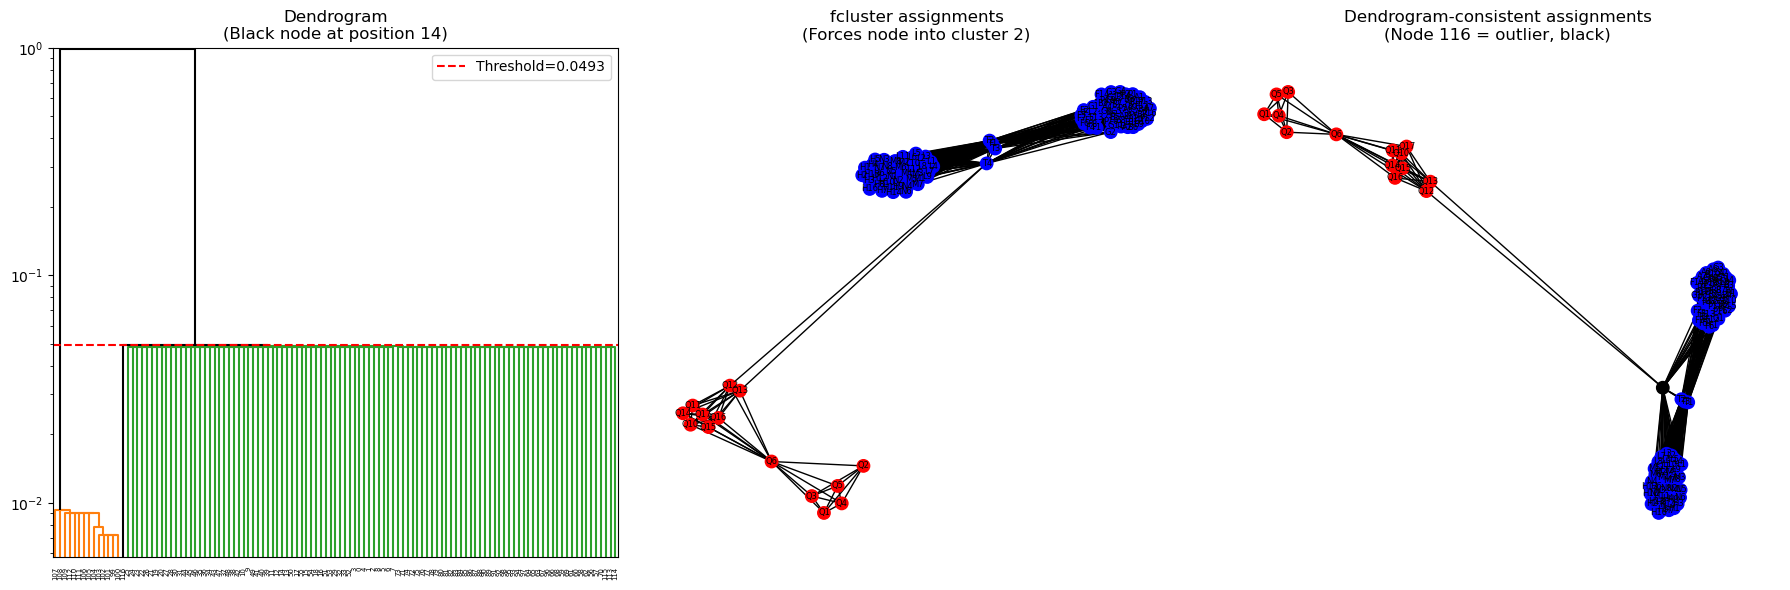


SUMMARY: Why fcluster and dendrogram don't match
1. Dendrogram coloring: Uses branches above/below threshold
   - Nodes that join clusters ABOVE threshold → colored black ('k')
   - This correctly identifies 'outlier' or 'bridge' nodes

2. fcluster function: Forces every node into exactly one cluster
   - No concept of 'outlier' nodes
   - Assigns outlier nodes to their nearest cluster

3. Solution: Extract cluster assignments from dendrogram colors
   - Cluster 0: Outliers (black nodes in dendrogram)
   - Cluster 1, 2, ...: Main clusters

In your case:
   - Node 116 is an outlier (joins clusters above threshold)
   - fcluster incorrectly assigns it to cluster 2
   - Consistent method correctly assigns it to cluster 0 (outlier)


In [231]:
# Visualization: Compare the two clustering approaches
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original fcluster result (forces all nodes into 2 clusters)
ax1 = axes[0]
dendro1 = dendrogram(
    linkage_matrix,
    ax=ax1,
    above_threshold_color='k',
    color_threshold=clTh,
)
ax1.axhline(clTh, ls='--', c='r', label=f'Threshold={clTh:.4f}')
ax1.set_yscale('log')
tmin = linkage_matrix[:, 2][0] * 0.8
tmax = linkage_matrix[:, 2][-1] * 1.01
ax1.set_ylim(tmin, tmax)
ax1.set_title(f'Dendrogram\n(Black node at position 14)')
ax1.legend()

# Plot 2: Network with fcluster coloring (incorrect)
ax2 = axes[1]
leaf_label_colors = {
    lbl: col for lbl, col in zip(dendro1['ivl'], dendro1['leaves_color_list'])
}
# Force fcluster assignments
fcluster_colors = ['red' if c == 1 else 'blue' for c in clusters]
nx.draw(Gcc, ax=ax2, node_color=fcluster_colors, 
        with_labels=True, labels=int_label_pos_map[patient]['label'], 
        font_size=6, node_size=80)
ax2.set_title('fcluster assignments\n(Forces node into cluster 2)')

# Plot 3: Network with consistent coloring (correct)
ax3 = axes[2]
consistent_colors = []
for c in consistent_clusters:
    if c == 0:
        consistent_colors.append('black')  # Outlier
    elif c == 1:
        consistent_colors.append('red')
    elif c == 2:
        consistent_colors.append('blue')

nx.draw(Gcc, ax=ax3, node_color=consistent_colors,
        with_labels=True, labels=int_label_pos_map[patient]['label'], 
        font_size=6, node_size=80)
ax3.set_title('Dendrogram-consistent assignments\n(Node 116 = outlier, black)')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY: Why fcluster and dendrogram don't match")
print("="*60)
print("1. Dendrogram coloring: Uses branches above/below threshold")
print("   - Nodes that join clusters ABOVE threshold → colored black ('k')")
print("   - This correctly identifies 'outlier' or 'bridge' nodes")
print("")
print("2. fcluster function: Forces every node into exactly one cluster")
print("   - No concept of 'outlier' nodes")  
print("   - Assigns outlier nodes to their nearest cluster")
print("")
print("3. Solution: Extract cluster assignments from dendrogram colors")
print("   - Cluster 0: Outliers (black nodes in dendrogram)")
print("   - Cluster 1, 2, ...: Main clusters")
print("")
print(f"In your case:")
print(f"   - Node 116 is an outlier (joins clusters above threshold)")
print(f"   - fcluster incorrectly assigns it to cluster 2")
print(f"   - Consistent method correctly assigns it to cluster 0 (outlier)")

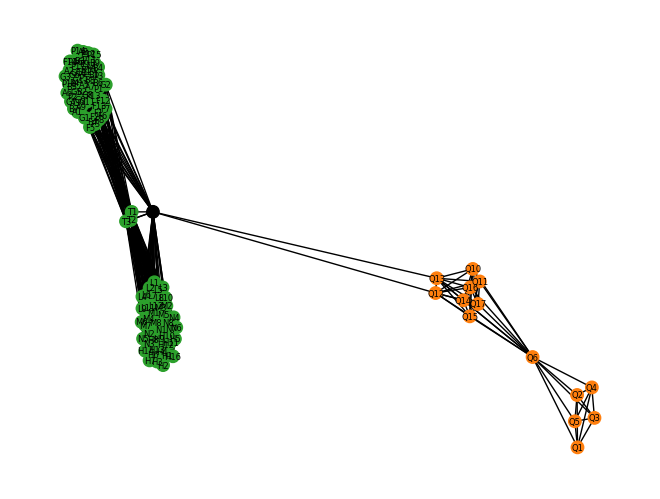

In [218]:
leaf_label_colors = {
    lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])
}
node_colors = [leaf_label_colors[str(n)] if n < len(leaf_label_colors) else 'gray' for n in Gcc.nodes()]
nx.draw(Gcc, node_color=node_colors, with_labels=True, labels=int_label_pos_map[patient]['label'], font_size=6, node_size=80)

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning:

divide by zero encountered in log

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning:

invalid value encountered in multiply



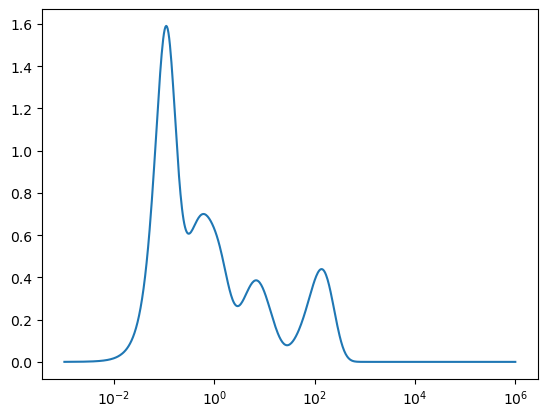

In [201]:
res = entropy(Gcc, t1=-3, t2=6)
plt.plot(res[-1][1:], res[1])
plt.xscale('log')

In [219]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.cluster.hierarchy import fcluster

def plot_metastable_sankey(G, tau_list, Trho_list, linkage_method="average", scaling_factor=0.8):
    """
    Plot Sankey diagram of metastable-node evolution across diffusion times tau.

    Parameters
    ----------
    G : nx.Graph
        Input graph (node labels preserved).
    tau_list : list[float]
        List of diffusion times τ in ascending order.
    Trho_list : list[np.ndarray]
        List of distance matrices (Trho) corresponding to each τ.
    linkage_method : str, optional
        Linkage method for hierarchical clustering (default "average").
    scaling_factor : float, optional
        Scaling for the flat clustering threshold (default 0.9).

    Returns
    -------
    go.Figure
        Plotly Sankey figure object.
    """
    from scipy.cluster.hierarchy import linkage
    from scipy.spatial.distance import squareform

    node_names = list(G.nodes())
    n_nodes = len(node_names)
    partitions = []

    # --- compute partitions for each tau ---
    for Trho in Trho_list:
        # condensed form of distance matrix
        dists = squareform(Trho, checks=False)
        linkage_matrix, _, _ = compute_normalized_linkage(dists, G, method=linkage_method)
        FlatClusteringTh, optTh, stabs, opt_idx = compute_optimal_threshold(linkage_matrix, scaling_factor)
        labels = fcluster(linkage_matrix, t=FlatClusteringTh, criterion="distance")
        partitions.append(labels)

    # --- align labels across successive tau's to maximize overlap ---
    from scipy.optimize import linear_sum_assignment

    aligned_partitions = [partitions[0]]
    for k in range(1, len(partitions)):
        prev, curr = aligned_partitions[-1], partitions[k]
        prev_labels, curr_labels = np.unique(prev), np.unique(curr)
        # build overlap matrix
        overlap = np.zeros((len(prev_labels), len(curr_labels)))
        for i, pl in enumerate(prev_labels):
            for j, cl in enumerate(curr_labels):
                overlap[i, j] = np.sum((prev == pl) & (curr == cl))
        # Hungarian alignment
        row_ind, col_ind = linear_sum_assignment(-overlap)
        mapping = {curr_labels[col_ind[j]]: prev_labels[row_ind[j]] for j in range(len(row_ind))}
        new_curr = np.array([mapping.get(l, max(prev_labels)+l) for l in curr])
        aligned_partitions.append(new_curr)

    # --- build Sankey links ---
    labels_all = [f"{t:.3f}" for t in tau_list]
    sources, targets, values, node_labels, color = [], [], [], [], []
    color_palette = plt.cm.tab20(np.linspace(0, 1, n_nodes))

    for i in range(len(tau_list)-1):
        prev, nxt = aligned_partitions[i], aligned_partitions[i+1]
        for l in np.unique(prev):
            for m in np.unique(nxt):
                count = np.sum((prev == l) & (nxt == m))
                if count > 0:
                    sources.append(f"{i}:{l}")
                    targets.append(f"{i+1}:{m}")
                    values.append(count)

    # Build list of unique nodes for Sankey
    unique_nodes = sorted(set(sources + targets))
    node_indices = {n: i for i, n in enumerate(unique_nodes)}
    src_idx = [node_indices[s] for s in sources]
    tgt_idx = [node_indices[t] for t in targets]

    # Build readable labels
    node_labels = [f"τ={tau_list[int(n.split(':')[0])]:.3f}\nC{n.split(':')[1]}" for n in unique_nodes]

    # --- Sankey diagram ---
    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(label=node_labels, pad=20, thickness=12, color="rgba(70,130,180,0.6)"),
        link=dict(source=src_idx, target=tgt_idx, value=values,
                  color="rgba(100,100,100,0.3)")
    ))
    return fig


In [220]:
patient = 'Pat_02'
phase = 'taskLearn' 
band_name = 'high_gamma'
interval_idx = 0  # Use first time interval

# Get the network and compute linkage matrix
Gcc = all_bands_networks[patient][phase][band_name][interval_idx]['G']
spectrum, L, rho, Trho, tau = compute_laplacian_properties(Gcc, tau=None)

lmax = max(spectrum)
taus = [0, 1/lmax, 2/lmax, 5/lmax, 1000/lmax][::-1]  # or logspace(…)
Trho_list = []
for tau in taus:
    _, L, rho, Trho, tau = compute_laplacian_properties(G, tau)
    Trho_list.append(Trho)

plot_metastable_sankey(G, taus, Trho_list)


## Sankey Diagram: Node Flow Through Communities Across Different Diffusion Timescales (τ)

This analysis shows how individual nodes move between communities as we vary the diffusion timescale parameter τ in the Laplacian-based distance computation. The τ parameter controls the diffusion process: τ = 1/λ where λ are the Laplacian eigenvalues. Small τ values (≈ 1/λ_max) capture fast dynamics and fine-scale structure, while large τ values (≈ 1/λ_min) reveal slow dynamics and coarse-scale organization.

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning:

divide by zero encountered in log

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning:

invalid value encountered in multiply



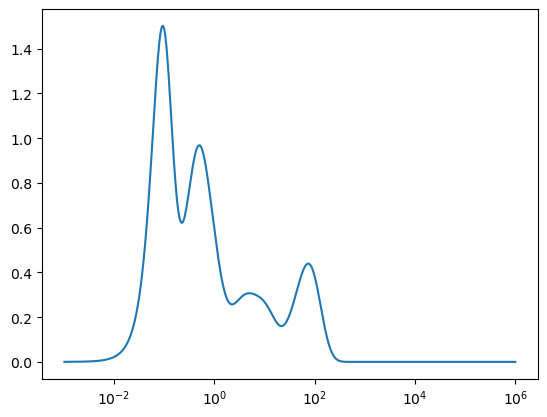

In [188]:
res = entropy(Gcc, t1=-3, t2=6)
plt.plot(res[-1][1:], res[1])
plt.xscale('log')

In [108]:
clustering_results

{'tau_0': array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 5, 5, 5, 5], dtype=int32),
 'tau_1': array([ 41,  33,  30,  31,  27,  28,  32,  51,  29,  40,  37,  38,  39,
         36,  34,  35,  49,  47,  48,  23,  24,  21,  19,  17,  18,  20,
         22,  15,  16,  70,  25,  26,  55,  54,  44,  42,  43,  45,  46,
         53,  52,  50,  69,  67,  60,  58,  56,  57,  59,  61,  63,  65,
         68,  66,  64,  62, 117, 116, 113, 114, 115, 110, 111, 109, 106,
        107, 108, 105, 103, 104, 112,  81,  79,  75,  76,  77,  78,  80,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  97,
         94,  95,  99, 101,  98, 102, 100,  96,  13,   9,

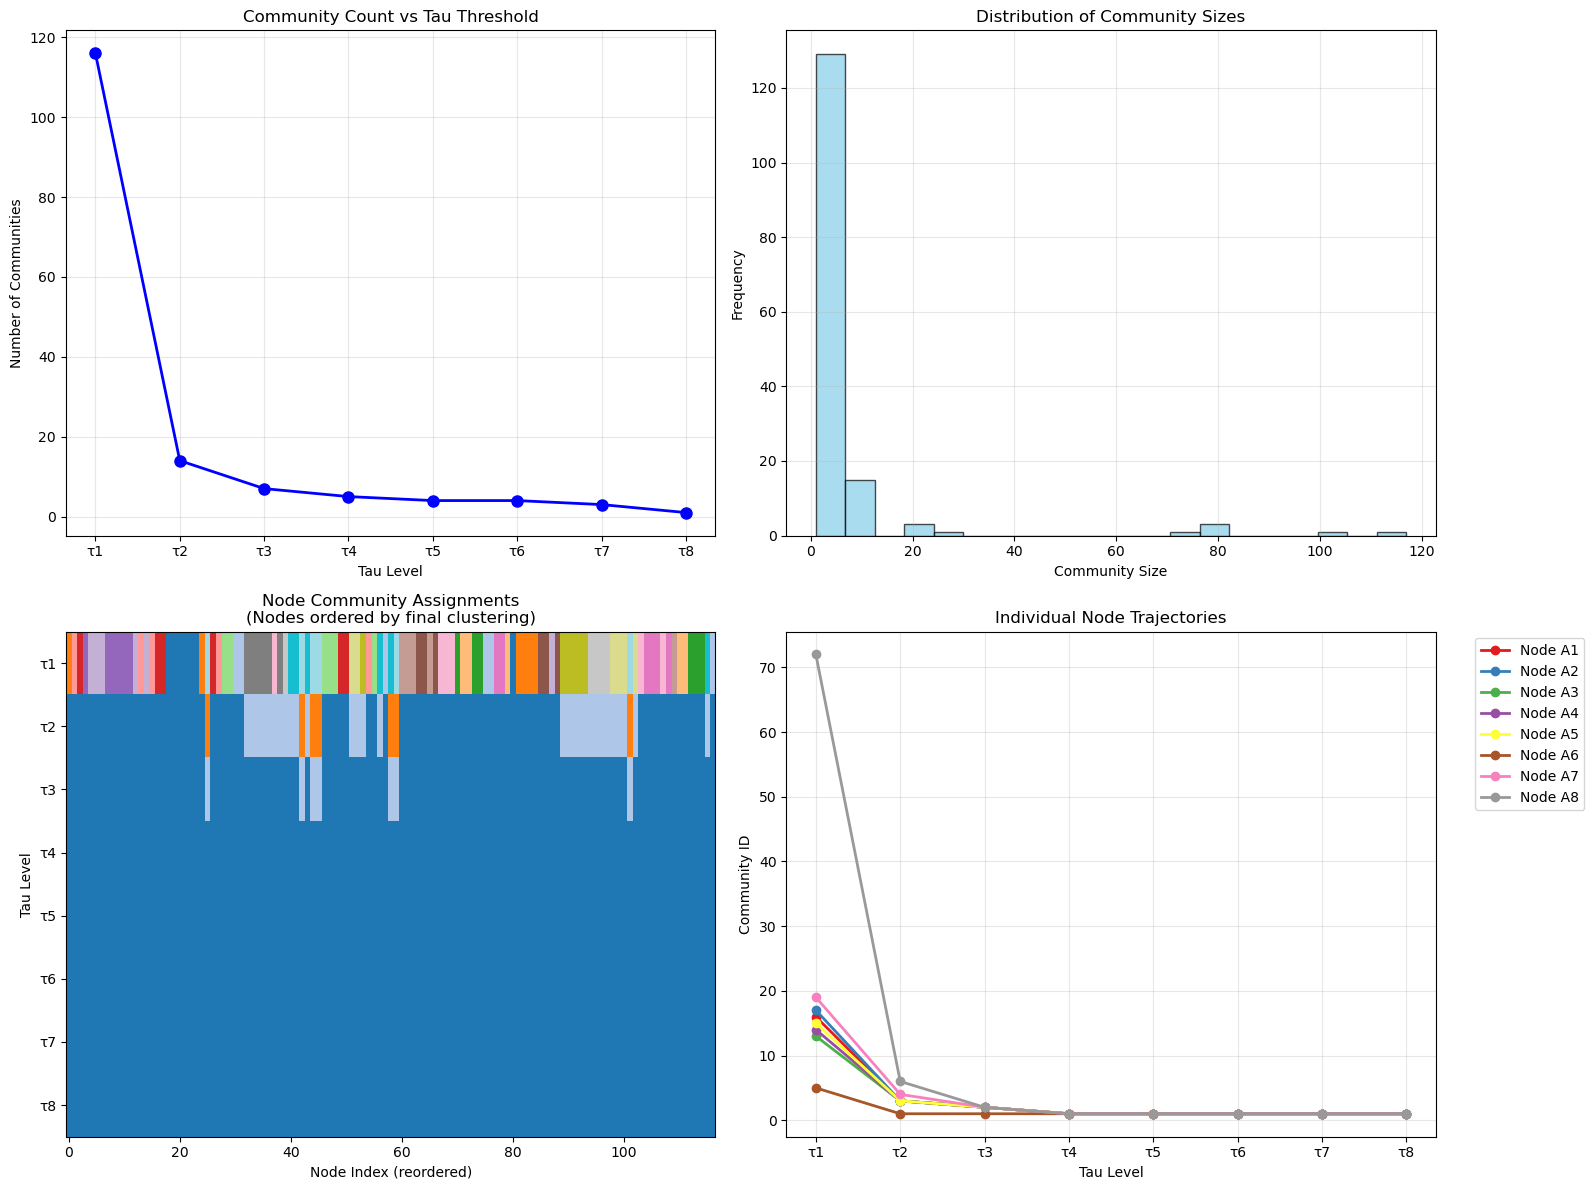


COMMUNITY FLOW ANALYSIS SUMMARY
Patient: Pat_02, Phase: rsPre, Band: beta
Number of nodes: 117
Tau range: 0.0000 to 0.9901
Number of tau levels analyzed: 8

Community counts at each tau level:
  Tau 1 (0.0000): 116 communities
  Tau 2 (0.0000): 14 communities
  Tau 3 (0.0000): 7 communities
  Tau 4 (0.0000): 5 communities
  Tau 5 (0.0002): 4 communities
  Tau 6 (0.0035): 4 communities
  Tau 7 (0.0587): 3 communities
  Tau 8 (0.9901): 1 communities

Stability metrics:
  Average community size: 6.08 ± 17.50
  Largest community size: 117
  Smallest community size: 1
  Average node transitions: 3.51 ± 1.34
  Most stable nodes (fewest transitions): 0
  Least stable nodes (most transitions): 6


In [ ]:
# Additional analysis: Community stability and node trajectories
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Number of communities vs diffusion timescale
n_communities = [len(np.unique(df_clusters[col])) for col in df_clusters.columns]
tau_labels = [f'τ={tau_values[i]}' for i in range(len(tau_values))]

axes[0,0].plot(range(len(tau_values)), n_communities, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Diffusion Timescale τ')
axes[0,0].set_ylabel('Number of Communities')
axes[0,0].set_title('Community Count vs Diffusion Timescale\n(τ=0: merged clusters → τ=large: separate clusters)')
axes[0,0].set_xticks(range(len(tau_values)))
axes[0,0].set_xticklabels(tau_labels, fontsize=8, rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Community size distribution
community_sizes = []
for col in df_clusters.columns:
    sizes = pd.Series(df_clusters[col]).value_counts().values
    community_sizes.extend(sizes)

axes[0,1].hist(community_sizes, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_xlabel('Community Size')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Community Sizes')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Heatmap of node assignments
# Reorder nodes by their final clustering to show patterns
final_clustering = df_clusters.iloc[:, -1]
node_order = np.argsort(final_clustering)
df_ordered = df_clusters.iloc[node_order]

im = axes[1,0].imshow(df_ordered.T, aspect='auto', cmap='tab20', interpolation='nearest')
axes[1,0].set_xlabel('Node Index (reordered)')
axes[1,0].set_ylabel('Tau Level')
axes[1,0].set_title('Node Community Assignments\n(Nodes ordered by final clustering)')
axes[1,0].set_yticks(range(len(tau_values)))
axes[1,0].set_yticklabels(tau_labels)

# Plot 4: Stability analysis - track a few specific nodes
axes[1,1].set_title('Individual Node Trajectories')
axes[1,1].set_xlabel('Tau Level')
axes[1,1].set_ylabel('Community ID')

# Select a few representative nodes to track
selected_nodes = pin_labels[:min(8, len(pin_labels))]  # First 8 nodes
colors_nodes = plt.cm.Set1(np.linspace(0, 1, len(selected_nodes)))

for i, node in enumerate(selected_nodes):
    trajectory = df_clusters.loc[node].values
    axes[1,1].plot(range(len(tau_values)), trajectory, 'o-', 
                   color=colors_nodes[i], label=f'Node {node}', linewidth=2, markersize=6)

axes[1,1].set_xticks(range(len(tau_values)))
axes[1,1].set_xticklabels(tau_labels, rotation=45)
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
fig.savefig(path_figs / f'community_analysis_{patient}_{phase}_{band_name}.pdf', 
            bbox_inches='tight', dpi=300)
plt.close()

# Print summary statistics
print("\n" + "="*60)
print("DIFFUSION TIMESCALE COMMUNITY ANALYSIS SUMMARY")
print("="*60)
print(f"Patient: {patient}, Phase: {phase}, Band: {band_name}")
print(f"Number of nodes: {len(pin_labels)}")
print(f"Diffusion timescale range: τ = {min(tau_values)} to {max(tau_values)}")
print(f"Number of τ levels analyzed: {len(tau_values)}")
print("\nCommunity counts at each diffusion timescale:")
for i, (tau, n_comm) in enumerate(zip(tau_values, n_communities)):
    print(f"  τ {i+1} ({tau}): {n_comm} communities")

# Calculate stability metrics
print(f"\nStability metrics:")
print(f"  Average community size: {np.mean(community_sizes):.2f} ± {np.std(community_sizes):.2f}")
print(f"  Largest community size: {max(community_sizes)}")
print(f"  Smallest community size: {min(community_sizes)}")

# Node stability - how often nodes change communities
stability_scores = []
for node in pin_labels:
    node_trajectory = df_clusters.loc[node].values
    changes = sum(node_trajectory[i] != node_trajectory[i+1] for i in range(len(node_trajectory)-1))
    stability_scores.append(changes)

print(f"  Average node transitions: {np.mean(stability_scores):.2f} ± {np.std(stability_scores):.2f}")
print(f"  Most stable nodes (fewest transitions): {np.min(stability_scores)}")
print(f"  Least stable nodes (most transitions): {np.max(stability_scores)}")